# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [َQuestion 1:](#1-0)
    - [َQuestion 2:](#1-1)
    - [َQuestion 3:](#1-12)
    - [َQuestion 4:](#1-2)
    - [َQuestion 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [َQuestion 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [36]:
# import
import numpy as np
import gym
import random
import math
import pygame
import time
from PIL import Image
import matplotlib.pyplot as plt

<a name='1'></a>
## Part 1: Value Iteration & Policy Iteration Algorithms

In [37]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode="rgb_array")

In [38]:
# get familiar with the environment
# print("you can see the environment in each step by render command :")
# env.reset()
# env.render()

In [39]:
# Total no. of states
env.observation_space.n

16

In [40]:
# Total no. of actions
env.action_space.n

4

<a name='1-0'></a>
### Question 1:

Value Iteration is a dynamic programming. In each episode, Value Estimation calculates new value of each state with the Belman equation. Best action is chosen based on the Q Value of each state.
The problem with value iteration is that policy converges way before value. Another problem is that it is slow.

<a name='1-1'></a>
### Question 2:

In [41]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))

    def value_estimation(self):
        self.delta = np.inf
        start_time = time.time()
        counter = 0
        while(self.delta > self.theta):

            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                        ### START CODE HERE ###
                        action_value += probability*(reward + (self.discount_factor*self.state_values[next_state]))
                        ### END CODE HERE ###
                    self.q_values[state, action] = action_value

                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

                if (self.delta < self.theta):
                    break
            counter += 1
        return (time.time() - start_time),counter

    def take_action(self, action):
        next_state, reward, done, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state

<a name='1-12'></a>
### Question 3:

In Policy Iteration we first choose a random policy and then calculate the state values with Belman Equation. The only difference is that we dont calculate the value for all actions.We run the algorithm with fixed policy for some episodes then policy gets updated. This algorithm is optimal like value iteration but alot faster.

<a name='1-2'></a>
### Question 4:

In [42]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) # initial policy
        self.policy_stable = False

    def policy_evaluation(self):
        self.delta = np.inf

        while(self.delta >= self.theta):

            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:
                    ### START CODE HERE ###
                    new_state_value += probability*(reward + (self.discount_factor*self.state_values[next_state]))
                    ### END CODE HERE ###
                self.state_values[state] = new_state_value

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    ### START CODE HERE ###
                    action_value += probability*(reward + (self.discount_factor*self.state_values[next_state]))
                    ### END CODE HERE ###
                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False
        start_time = time.time()
        counter = 0
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
            counter+=1
        return (time.time() - start_time) ,counter

    def take_action(self, action):
        next_state, reward, done, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state

In [43]:
def env_render(env,DISPLAYSURF,fps): 
    image = env.render()
    image = Image.fromarray(image,'RGB')
    mode,size,data = image.mode,image.size,image.tobytes()
    image = pygame.image.fromstring(data,size,mode)
    # image = convert_observation(image)
    DISPLAYSURF.blit(image,(0,0))
    pygame.display.update()
    time.sleep(fps)

<a name='1-3'></a>
### Question 5:

In [44]:
windows_width = 400
windows_height = 400



row = 4
col = 4

rect_side = windows_height/4

In [45]:
def draw_optimal_policy(caption,q_values):
    pygame.init()
    display_surface = pygame.display.set_mode((windows_width, windows_height))
    pygame.display.set_caption(caption)
    display_surface.fill((255,255,204))
    y = 0
    for i in range(row):
        x = 0
        for j in range(col):
            q_s = q_values[(4*i)+j,:]    
            action = np.argmax(q_s)
            image = pygame.image.load('arrow.png').convert()
            image = pygame.transform.rotate(image, 90*action)
            rect = image.get_rect()
            rect.center = (x+(rect_side/2), y+(rect_side/2))
            display_surface.blit(image,rect)
            x += rect_side
        y+= rect_side         
    for i in range(1,row):
        pygame.draw.line(display_surface,(0,0,0),(0,i*(windows_height/row)),(windows_width,i*(windows_height/row)))
    for i in range(1,row):
        pygame.draw.line(display_surface,(0,0,0),(i*(windows_width/row),0),(i*(windows_width/row),windows_height))

<a name='1-3-1'></a>
#### Value Iteration:

In [46]:
discount_factor = 0.9


In [47]:

LakeVI = ValueIteration(env,discount_factor)



initial_state = LakeVI.reset()[0]
LakeVI.value_estimation()
end = 0
current_state = initial_state
DISPLAYSURF = pygame.display.set_mode((250, 250))
pygame.init()

while not end:
    current_action = LakeVI.get_optimal_policy(int(current_state))
    current_state,_,end,_,_ = env.step(current_action)
    env_render(env,DISPLAYSURF,1)    
pygame.quit()
    
    


In [48]:
draw_optimal_policy("optimal policy in value iteration",LakeVI.get_q_values())
finished = 0
while not finished : 
    for event in pygame.event.get() : 
  
        if event.type == pygame.QUIT : 
  
            pygame.quit()
            finished = 1
            break
    if not finished:
        pygame.display.update() 

<a name='1-3-2'></a>
#### Policy Iteration:

In [49]:

LakePI = PolicyIteration(env,discount_factor)
initial_state = LakePI.reset()[0]
LakePI.policy_estimation()
end = 0
current_state = initial_state
DISPLAYSURF = pygame.display.set_mode((250, 250))
pygame.init()

while not end:
    current_action = LakePI.get_optimal_policy(int(current_state))
    current_state,_,end,_,_ = env.step(current_action)
    env_render(env,DISPLAYSURF,1)
    
pygame.quit()
    
    

In [50]:
draw_optimal_policy("optimal policy in policy iteration",LakeVI.get_q_values())
finished = 0
while not finished : 
    for event in pygame.event.get() : 
  
        if event.type == pygame.QUIT : 
  
            pygame.quit()
            finished = 1
            break
    if not finished:
        pygame.display.update() 

<a name='1-4'></a>
### Question 6:

In [51]:
repeats = 100

In [52]:
def draw_values(caption,state_values):
    pygame.init()
    display_surface = pygame.display.set_mode((windows_width, windows_height))
    # font = pygame.font.Font(None,20)
    pygame.display.set_caption(caption)
    display_surface.fill((255,255,255))
    font = pygame.font.Font('freesansbold.ttf', 12)
    y = 0
    for i in range(row):
        x = 0
        for j in range(col):
            value = state_values[(4*i)+j]
            if value >= 0:
                pygame.draw.rect(display_surface,(124,252,0),(x,y,rect_side,rect_side),0)
            else:
                pygame.draw.rect(display_surface,(255,0,0),(x,y,rect_side,rect_side),0)
            s = pygame.Surface((windows_height,windows_width))
            s.set_alpha(255 - abs(value)*255)                
            s.fill((255,255,255))           
            display_surface.blit(s, (x,y)) 
            text = font.render(str(round(value,3)),True,(0,0,0))
            textRect = text.get_rect()
            textRect.center = (x+(rect_side/2), y+(rect_side/2))
            display_surface.blit(text,textRect)
            x += rect_side
        y+= rect_side         
    for i in range(1,row):
        pygame.draw.line(display_surface,(0,0,0),(0,i*(windows_height/row)),(windows_width,i*(windows_height/row)))
    for i in range(1,row):
        pygame.draw.line(display_surface,(0,0,0),(i*(windows_width/row),0),(i*(windows_width/row),windows_height))

<a name='1-4-1'></a>
#### Value Iteration:

In [53]:


LakeVI = ValueIteration(env,discount_factor)
LakeVI.reset()
LakeVI.value_estimation()
draw_values("value iteration",LakeVI.get_state_values())
finished = 0
while not finished : 
    for event in pygame.event.get() : 

        if event.type == pygame.QUIT : 
  
            pygame.quit()
            finished = 1
            break
            
  
    if not finished:
        pygame.display.update() 
print(LakeVI.get_q_values())

[[0.531441   0.59049    0.59049    0.531441  ]
 [0.531441   0.13286025 0.6561     0.59049   ]
 [0.59049    0.729      0.59049    0.6561    ]
 [0.6561     0.13286025 0.59049    0.59049   ]
 [0.59049    0.6561     0.13286025 0.531441  ]
 [0.13286025 0.13286025 0.13286025 0.13286025]
 [0.11957423 0.81       0.13286025 0.6561    ]
 [0.13286025 0.13286025 0.13286025 0.13286025]
 [0.6561     0.13286025 0.729      0.59049   ]
 [0.6561     0.81       0.81       0.11957423]
 [0.729      0.9        0.13286025 0.729     ]
 [0.13286025 0.13286025 0.13286025 0.13286025]
 [0.13286025 0.13286025 0.13286025 0.13286025]
 [0.11957423 0.81       0.9        0.729     ]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]


<a name='1-4-2'></a>
#### Policy Iteration:

In [54]:
LakePI = PolicyIteration(env,discount_factor)
LakePI.reset()
LakePI.policy_estimation()
draw_values("policy iteration",LakePI.get_state_values())
finished = 0
while not finished : 
    for event in pygame.event.get() : 
  
        if event.type == pygame.QUIT : 
  
            pygame.quit()
            finished = 1
            break
    if not finished:
        pygame.display.update() 
print(LakePI.get_q_values())

[[5.31441000e-01 5.90490000e-01 5.90490000e-01 5.31441000e-01]
 [5.31441000e-01 1.81874361e-08 6.56100000e-01 5.90490000e-01]
 [5.90490000e-01 7.29000000e-01 5.90490000e-01 6.56100000e-01]
 [6.56100000e-01 1.81874361e-08 5.90490000e-01 5.90490000e-01]
 [5.90490000e-01 6.56100000e-01 1.81874361e-08 5.31441000e-01]
 [1.81874361e-08 1.81874361e-08 1.81874361e-08 1.81874361e-08]
 [1.81874361e-08 8.10000000e-01 1.81874361e-08 6.56100000e-01]
 [1.81874361e-08 1.81874361e-08 1.81874361e-08 1.81874361e-08]
 [6.56100000e-01 1.81874361e-08 7.29000000e-01 5.90490000e-01]
 [6.56100000e-01 8.10000000e-01 8.10000000e-01 1.81874361e-08]
 [7.29000000e-01 9.00000000e-01 1.81874361e-08 7.29000000e-01]
 [1.81874361e-08 1.81874361e-08 1.81874361e-08 1.81874361e-08]
 [1.81874361e-08 1.81874361e-08 1.81874361e-08 1.81874361e-08]
 [1.81874361e-08 8.10000000e-01 9.00000000e-01 7.29000000e-01]
 [8.10000000e-01 9.00000000e-01 1.00000000e+00 8.10000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

# Plots:

In [55]:
v_times = []
v_number_of_episodes = []
for i in range(repeats):
    LakeVI = ValueIteration(env,discount_factor)
    LakeVI.reset()
    spent_time ,episodes  =LakeVI.value_estimation()
    v_times.append(round(spent_time,3))
    v_number_of_episodes.append(episodes)




q_times = []
q_number_of_episodes = []
for i in range(repeats):
    LakePI = PolicyIteration(env,discount_factor)
    LakePI.reset()
    spent_time ,episodes  =LakePI.policy_estimation()
    q_times.append(round(spent_time,3))
    q_number_of_episodes.append(episodes)


[]

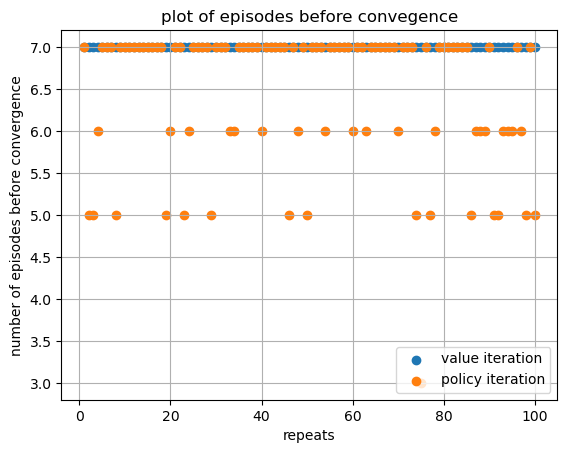

In [56]:

reps = [i+1 for i in range(repeats)]
plt.scatter(reps,v_number_of_episodes)
plt.scatter(reps,q_number_of_episodes)
plt.legend(['value iteration','policy iteration'], loc = 'lower right')
plt.xlabel("repeats")
plt.ylabel("number of episodes before convergence")
plt.title("plot of episodes before convegence")
plt.grid()
plt.plot()


Policy iteration often converges before value iteration because policy iteration greedily chooses the best policy every time and this may rsult in faster convergence. On the other hand Value iteration only calculates the value of states and doesnt explicitly chooses the policy.

[]

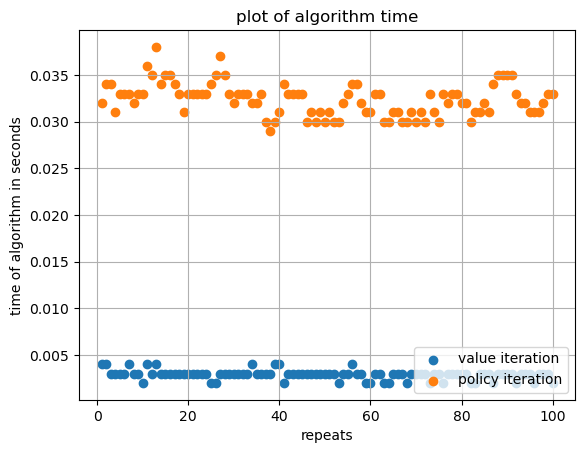

In [57]:

reps = [i+1 for i in range(repeats)]
plt.scatter(reps,v_times)
plt.scatter(reps,q_times)
plt.legend(['value iteration','policy iteration'], loc = 'lower right')
plt.xlabel("repeats")
plt.ylabel("time of algorithm in seconds")
plt.title("plot of algorithm time")
plt.grid()
plt.plot()

Policy Iteration should be faster but because of simplicity of the problem our plot is not really valid because order of difference is about 0.02 seconds.

<a name='2'></a>
## Part 2: Q-Learning Algorithm

<a name='2-1'></a>
### Question 7:

QLearning is a model-free passive RL method which learns in an unkown environment.In each state our agent will choose the optimal action and updates the Q-Value based on the reward it receives. This method can not find Q-value of states it has not visisted. Being model-free and has advantage of being more flexible in solving different situations of the same problem. And above all with sufficient exploration Q-Learning will converge to optimal policy.

<a name='2-1'></a>
### Question 8:

In [58]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.15
LEARNING_RATE = 0.3
DISCOUNT = 0.9
STUDENT_NUM = 187

In [59]:
# # environment
env = gym.make('Taxi-v3',render_mode="rgb_array")
Initial_State = env.reset(seed=STUDENT_NUM)[0]
# image = env.render()
# image = Image.fromarray(image,'RGB')
# image.show()


In [60]:
taxi_row, taxi_col, pass_idx, dest_idx = env.decode(Initial_State)
taxi_row, taxi_col, pass_idx, dest_idx

(1, 1, 1, 2)

In [61]:
# get familiar with the environment
print("you can see the environment in each step by render command :")
# env.render()

you can see the environment in each step by render command :


In [62]:
# Total no. of states
env.observation_space.n

500

In [63]:
# Total no. of actions
env.action_space.n

6

In [64]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
      self.env = env
      self.epsilon = epsilon
      self.learning_rate = learning_rate
      self.olr = learning_rate
      self.discount_factor = discount_factor
      self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
      self.seed = seed
      self.INITLEARNINGRATE = learning_rate
      self.INITEPSILON = epsilon

    def choose_action(self, state):
      ### START CODE HERE ###
      chance = random.random()
      if chance < self.epsilon:
        action = random.randint(0,5)
      else:
        action = self.get_optimal_policy(state)
      ### END CODE HERE ###
      return action

    def update_q_table(self, state, action, nextState, reward):
      ### START CODE HERE ###
      self.q_table[state,action] = ((1-self.learning_rate)*(np.copy(self.q_table[state,action]))) + (self.learning_rate*(reward + (self.discount_factor*np.max(self.q_table[nextState,:]))))
      ### END CODE HERE ###

    def decay_epsilon(self, episode):
      ### START CODE HERE ###
      if episode %10 == 0:
        self.epsilon = self.INITEPSILON* (0.95**(math.floor((1+episode)/20)))
        
      ### END CODE HERE ###

    def decrease_learning_rate(self, episode):
      ### START CODE HERE ###
      if episode %10 == 0:
        self.learning_rate = self.INITLEARNINGRATE* (0.95**(math.floor((1+episode)/50)))
      ### END CODE HERE ###

    def take_action(self, action):
      next_state, reward, done, _,_ = self.env.step(action)
      return next_state, reward, done

    def get_optimal_policy(self, state):
      return np.argmax(self.q_table[state])

    def get_q_values(self):
      return self.q_table

    def reset(self):
      # self.learning_rate = self.olr
      return self.env.reset(seed=self.seed)

In [65]:
# base code for Q-learning
def Train_QLearning(env,decreasing_learning_rate):

    
    total_rewards = []
    total_time = []
    agent = QLearningAgent(env,EPSILON,LEARNING_RATE,DISCOUNT,STUDENT_NUM)
    for rep in range(REPS):
        rewards = []
        times = []
        agent = QLearningAgent(env,EPSILON,LEARNING_RATE,DISCOUNT,STUDENT_NUM)     
        for episode in range(EPISODES):
            Initial_state = env.reset(seed=STUDENT_NUM)[0]
            current_state = Initial_state
            done = 0
            reward_sum = 0
            start = time.time()
            while not done:
                action = agent.choose_action(current_state)
                next_state, reward,done = agent.take_action(action)
                reward_sum += reward
                agent.update_q_table(current_state,action,next_state,reward)
                current_state = next_state
                if done:
                    break
            agent.decay_epsilon(episode)
            if decreasing_learning_rate:
                agent.decrease_learning_rate(episode)
        
            times.append(time.time()-start)
            rewards.append(reward_sum)

        total_time.append(times) 
        total_rewards.append(rewards.copy())
        if rep == REPS-1:
            return agent.get_q_values(), total_rewards,total_time
    

In [66]:
env = gym.make('Taxi-v3',render_mode="rgb_array")
q_value2, total_rewards2,total_time2 = Train_QLearning(env,decreasing_learning_rate=False)
q_value1, total_rewards1,total_time1 = Train_QLearning(env,decreasing_learning_rate = True)


<a name='2-2'></a>
### Question 9:

In [67]:
def mean_reward(total_rewards):
    rewards = []
    for i in range(EPISODES):
        sum = 0
        for j in range(REPS):
            sum+=total_rewards[j][i]
        rewards.append(sum/REPS)
    return rewards

def mean_time(total_time):
    times = []
    for i in range(EPISODES):
        sum = 0
        for j in range(REPS):
            sum+=total_time[j][i]
        times.append(round(sum/REPS,3))
    return times



[]

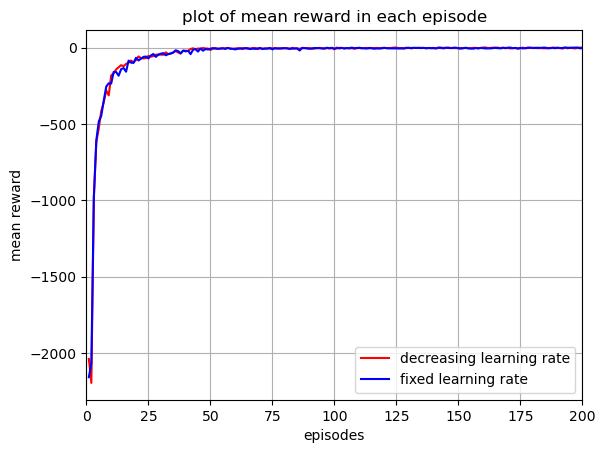

In [68]:
mean_rewards1 = mean_reward(total_rewards1)
mean_rewards2 = mean_reward(total_rewards2)
eps = [i+1 for i in range(EPISODES)]

plt.plot(eps,mean_rewards1,"red")
plt.plot(eps,mean_rewards2,"blue")
plt.legend(['decreasing learning rate','fixed learning rate'], loc = 'lower right')
plt.xlabel("episodes")
plt.ylabel("mean reward")
plt.xlim(0,200)
plt.grid()
plt.title("plot of mean reward in each episode")
plt.plot()


Decreasing learning rate has helped the convergence of our problem but not quite alot.
In bigger problems with more states, decreasing learning rate helps the convergence and stability of the agent and our agent will gradually improve.
Role of learning rate is to keep learning new things and agent experiences balance so that our agent have both together.

[]

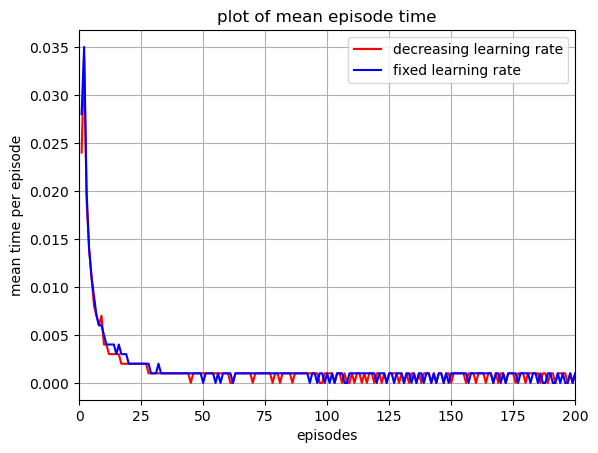

In [69]:
mean_time1 = mean_time(total_time1)
mean_time2 = mean_time(total_time2)
eps = [i+1 for i in range(EPISODES)]

plt.plot(eps,mean_time1,"red")
plt.plot(eps,mean_time2,"blue")
plt.legend(['decreasing learning rate','fixed learning rate'], loc = 'upper right')
plt.xlabel("episodes")
plt.ylabel("mean time per episode")
plt.title("plot of mean episode time")
plt.xlim(0,200)
plt.grid()
plt.plot()

As shown above the reward values and convergence time are almost the same and decreasing learning rate converges only a bit faster.
Epsilon decay and learning rate decay are calculated with step decay formula every 10 episode:

$lr = lr0 \times (0.95^{\lfloor (1 + \text{{episode}})/50 \rfloor})$

$epsilon = epsilon0 \times (0.95^{\lfloor (1 + \text{{episode}})/50 \rfloor})$


There are other types of decay such as exponential decay, linear decay and polynomial decay. Finding the best decay method can only be done by experimenting. In this case step decay gave me the fastest convergence speed.
                     

<a name='2-3'></a>
### Question 10:

In [70]:
DISPLAYSURF = pygame.display.set_mode((550, 350))
pygame.init()
Initial_State = env.reset(seed=STUDENT_NUM)[0]
current_state = 2
done = 0
while not done:
    action = np.argmax(q_value2[current_state,:])
    next_state, reward,done,_,_ = env.step(action)
    current_state = next_state
    env_render(env,DISPLAYSURF,1)
    if done:
        break
pygame.quit()

